# Chapter 1: Maryland Automotive Industry - Data Preparation

### Import Packages

In [1]:
import pandas as pd # for dataframe 
from datetime import datetime # for time differencing
import matplotlib.pyplot as plt # for plotting

### Import Functions

#### Renaming Data
- Turning columns to snakecase

In [2]:
import re

def camel_to_snake(column_names):
    def convert(name):
        name = name.strip()
        name = re.sub(r'\s+', '_', name).lower()
        name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name).lower()
        return name
    
    return [convert(name) for name in column_names]

# use this function to create dataframes with appropriate column names
def rename_columns_to_snake_case(df):
    df.columns = camel_to_snake(df.columns)
    return df


#### Transform Dataframe 
- Convert wide data to long data
- Create monthly wide data from long data
- Normalise Data

In [3]:
def convert_to_long_format(df, start_date, end_date,col_name, freq='Q'):
    """
    Converts a wide-format DataFrame to a long-format DataFrame with a DateTime index.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with years or periods as rows and quarters, months, weeks, or days as columns.
    - start_date (str): The start date for the DateTime index.
    - end_date (str): The end date for the DateTime index.
    - freq (str): The frequency for the DateTime index. Options are 'D' (day), 'M' (month), 'W' (week), 'Q' (quarter).

    Returns:
    - pd.DataFrame: A long-format DataFrame with a DateTime index.
    """
    long_data = []
    for index, row in df.iterrows():
        for period in df.columns:
            long_data.append(row[period])

    long_df = pd.DataFrame({col_name: long_data})

    # Adjust the DateTime index based on the frequency
    if freq == 'D':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='D'), inplace=True)
    elif freq == 'M':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='M'), inplace=True)
    elif freq == 'W':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='W'), inplace=True)
    elif freq == 'Q':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='Q'), inplace=True)
    else:
        raise ValueError("Frequency not recognized. Use 'D' for day, 'M' for month, 'W' for week, or 'Q' for quarter.")
    
    long_df.index = long_df.index - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)
        
    return long_df

In [4]:
def create_monthly_data(df, value_column, start_date, end_date):
    # Define months
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    
    # Convert start and end dates to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Generate date range for the given period
    date_range = pd.date_range(start=start_date, end=end_date, freq='M')
    
    # Create a DataFrame with years as index and months as columns
    years = date_range.year.unique()
    monthly_data = pd.DataFrame(index=years, columns=months)
    
    # Fill the empty DataFrame
    for date, row in df.iterrows():
        if start_date <= date <= end_date:
            year = date.year
            month = months[date.month - 1]  # Months are 1-indexed
            if year in monthly_data.index and month in monthly_data.columns:
                monthly_data.at[year, month] = row[value_column]

    return monthly_data

In [5]:
def normalize_data(df_series):

    # Find minimum and maximum values in the specified column
    min_val = df_series.min()
    max_val = df_series.max()

    # Normalize the specified column
    normalized_series = (df_series - min_val) / (max_val - min_val)

    return normalized_series

#### Calculate Growth
- Calculate Growth
- Create Year over Year movement

In [6]:
def calculate_growth(df, value_column):
    """
    Calculate the growth of a specified value column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame in long format.
    value_column (str): The name of the column containing the values for which growth needs to be calculated.
    time_column (str): The name of the column containing the time information (for sorting purposes).

    Returns:
    pd.DataFrame: A DataFrame with the calculated growth.
    """
    # Ensure the DataFrame is sorted by the time column)

    new_df = df.copy()

    # Calculate the growth using .diff() and create a new column
    new_df['growth'] = df[value_column].diff() / df[value_column].shift(1) * 100

    new_df.drop(columns=value_column,inplace=True)

    return new_df

In [7]:
def compare_yearly(df, period='monthly'):
    """
    Compares how the month or quarter of the previous year compares with the current year.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with index as years and columns as months or quarters.
    - period (str): The period of the data ('monthly' or 'quarterly').
    
    Returns:
    - pd.DataFrame: DataFrame showing the percentage change from the previous year.
    """
    # Ensure the DataFrame is sorted by index (years)
    df = df.sort_index()

    # Calculate the percentage change
    comparison_df = df.pct_change(periods=1, axis=0) * 100

    # Return the DataFrame with the percentage change
    return comparison_df

#### Plot Data
- Plot multiple series

In [8]:
#Create a function that plots multiple lines
def plot_multiple_series_multiple_xvalues(xvalues,yvalues,labels,title,xlabel,ylabel):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        plt.plot(xvalues[i], yvalues[i], label=labels[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
#Create a function that plots multiple lines
def plot_multiple_series_one_xvalues(xvalues,yvalues,labels,title,xlabel,ylabel):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        plt.plot(xvalues, yvalues[i], label=labels[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

## Car Sales Data

### MVA Vehicle Sales Counts Data
The 'sales_data' dataset is from the Maryland State Government. It was implemented in July of 2020 which has kept records up until the beginning of 2002. This is updated on a monthly basis and is based on electornic submissions from dealers and other vendors.

The full information regarding this dataset can be found in the bibliography in 'reports'.

In [10]:
# import the sales data
sales_data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/cars_datasets/MVA_Vehicle_Sales_Counts_by_Month_for_Calendar_Year_2002_through_December_2023.csv')
sales_data

,Year,Month,New,Used,Total Sales New,Total Sales Used
0,2002,JAN,31106,49927,755015820,386481929
1,2002,FEB,27520,50982,664454223,361353242
2,2002,MAR,34225,58794,805666244,419385387
3,2002,APR,36452,59817,846368297,433061150
4,2002,MAY,37359,60577,855005784,442569410
...,...,...,...,...,...,...
259,2023,AUG,25876,52725,1222581892,908454060
260,2023,SEP,23892,45386,1134437699,744676584
261,2023,OCT,23775,45473,1122680147,740582533
262,2023,NOV,22720,42260,1062465105,694190564


In [11]:
# rename the columns to be in snake case
sales_data = rename_columns_to_snake_case(sales_data)
sales_data

,year,month,new,used,total_sales_new,total_sales_used
0,2002,JAN,31106,49927,755015820,386481929
1,2002,FEB,27520,50982,664454223,361353242
2,2002,MAR,34225,58794,805666244,419385387
3,2002,APR,36452,59817,846368297,433061150
4,2002,MAY,37359,60577,855005784,442569410
...,...,...,...,...,...,...
259,2023,AUG,25876,52725,1222581892,908454060
260,2023,SEP,23892,45386,1134437699,744676584
261,2023,OCT,23775,45473,1122680147,740582533
262,2023,NOV,22720,42260,1062465105,694190564


In [12]:
# rename columns to be more appropriate
sales_data.rename(columns={'new':'new_cars_sold',
                           'used':'used_cars_sold',
                           'total_sales_new':'new_value_cars_sold',
                           'total_sales_used':'used_value_cars_sold'},inplace=True)

In [13]:
# dictionary mapping month names to numbers
month_mapping = {
    "JAN": 1,
    "FEB": 2,
    "MAR": 3,
    "APR": 4,
    "MAY": 5,
    "JUN": 6,
    "JUL": 7,
    "AUG": 8,
    "SEP": 9,
    "OCT": 10,
    "NOV": 11,
    "DEC": 12
}

# replace month names with numbers in the specified column
sales_data['month'] = sales_data['month'].replace(month_mapping)

In [14]:
# create a 'date' column
date_column = pd.to_datetime(sales_data[['year', 'month']].assign(DAY=1), format='%Y-%m-%d')

# insert the column into the first column index
sales_data.insert(0,'date',date_column)

sales_data.set_index('date',inplace=True)

# drop the old columns
sales_data.drop(columns={'year','month'},inplace=True)

#### Sales Data Column Creation
Create the following columns

- total_cars_sold : find the total number of cars sold
- total_value_cars_sold : find the total value of cars sold

In [15]:
# get the total cars sold and insert at appropriate position
total_cars_sold = sales_data['new_cars_sold'] + sales_data['used_cars_sold']
sales_data.insert(0,'total_cars_sold',total_cars_sold)

# get the total value of cars sold and insert at appropriate position
total_value_cars_sold = sales_data['new_value_cars_sold'] + sales_data['used_value_cars_sold']
sales_data.insert(3,'total_value_cars_sold',total_value_cars_sold)

sales_data

,total_cars_sold,new_cars_sold,used_cars_sold,total_value_cars_sold,new_value_cars_sold,used_value_cars_sold
date,,,,,,
2002-01-01,81033,31106,49927,1141497749,755015820,386481929
2002-02-01,78502,27520,50982,1025807465,664454223,361353242
2002-03-01,93019,34225,58794,1225051631,805666244,419385387
2002-04-01,96269,36452,59817,1279429447,846368297,433061150
2002-05-01,97936,37359,60577,1297575194,855005784,442569410
...,...,...,...,...,...,...
2023-08-01,78601,25876,52725,2131035952,1222581892,908454060
2023-09-01,69278,23892,45386,1879114283,1134437699,744676584
2023-10-01,69248,23775,45473,1863262680,1122680147,740582533


In [16]:
# save the data to 'prepared_datasets'
sales_data.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/sales_data.csv')

### MVA Electric and Plug-in Hybrid Vehicle
The 'ecar_sales_data' dataset is from the Maryland State Government. It is updated on a monthly basis and has data collected as of July 2020.

The full information regarding this dataset can be found in the bibliography in 'reports'.


In [17]:
# read in the electric car vehicle data
ecar_sales_data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/cars_datasets/MD_MDOT_MVA_Electric_and_Plug-in_Hybrid_Vehicle_Registrations_by_Zip_Code_as_of_Each_Month_End_from_July_2020_to_April_2024.csv')
ecar_sales_data

,Year_Month,Fuel_Category,Zip_Code,Count
0,2020/07,Electric,19973,1
1,2020/07,Electric,20601,21
2,2020/07,Electric,20602,26
3,2020/07,Electric,20603,54
4,2020/07,Electric,20607,35
...,...,...,...,...
58297,2024/04,Plug-In Hybrid,95130,1
58298,2024/04,Plug-In Hybrid,95628,1
58299,2024/04,Plug-In Hybrid,97703,1
58300,2024/04,Plug-In Hybrid,98045,1


In [18]:
# rename the columns to industry standards
ecar_sales_date = rename_columns_to_snake_case(ecar_sales_data)
ecar_sales_data

,year_month,fuel_category,zip_code,count
0,2020/07,Electric,19973,1
1,2020/07,Electric,20601,21
2,2020/07,Electric,20602,26
3,2020/07,Electric,20603,54
4,2020/07,Electric,20607,35
...,...,...,...,...
58297,2024/04,Plug-In Hybrid,95130,1
58298,2024/04,Plug-In Hybrid,95628,1
58299,2024/04,Plug-In Hybrid,97703,1
58300,2024/04,Plug-In Hybrid,98045,1


In [19]:
# convert the current object dtype date form into datetime format
ecar_sales_data['date'] = ecar_sales_data['year_month'].apply(lambda x: datetime.strptime(x, '%Y/%m'))

# set the index to date
ecar_sales_data.set_index('date',inplace=True)

# drop the original data
ecar_sales_data.drop(columns='year_month',inplace=True)

ecar_sales_data

,fuel_category,zip_code,count
date,,,
2020-07-01,Electric,19973,1
2020-07-01,Electric,20601,21
2020-07-01,Electric,20602,26
2020-07-01,Electric,20603,54
2020-07-01,Electric,20607,35
...,...,...,...
2024-04-01,Plug-In Hybrid,95130,1
2024-04-01,Plug-In Hybrid,95628,1
2024-04-01,Plug-In Hybrid,97703,1


In [20]:
# drop the 'in' and replace with 'In'
# this will reduce the redundancy in recording of data
ecar_sales_data['fuel_category'] = ecar_sales_data['fuel_category'].apply(lambda x: x.replace('in', 'In'))

In [21]:
# convert the data to be sorted by both 'date' and 'fuel_category'
ecar_sales_data = ecar_sales_data.groupby(['date', 'fuel_category'])['count'].sum().reset_index()
ecar_sales_data

,date,fuel_category,count
0,2020-07-01,Electric,15192
1,2020-07-01,Plug-In Hybrid,11026
2,2020-08-01,Electric,15578
3,2020-08-01,Plug-In Hybrid,11153
4,2020-09-01,Electric,15889
...,...,...,...
87,2024-02-01,Plug-In Hybrid,29622
88,2024-03-01,Electric,69529
89,2024-03-01,Plug-In Hybrid,30216
90,2024-04-01,Electric,71715


In [22]:
# pivot the table so that the columns are based on the categorical variable of 'fuel_category'
ecar_sales_data = ecar_sales_data.pivot(index='date', columns='fuel_category', values='count')
ecar_sales_data.head()

fuel_category,Electric,Plug-In Hybrid
date,,
2020-07-01,15192,11026
2020-08-01,15578,11153
2020-09-01,15889,11297
2020-10-01,16549,11453
2020-11-01,16906,11669


In [23]:
# total electric/hybrid car sales
ecar_sales_data['total_electric_sales'] = ecar_sales_data['Electric'] + ecar_sales_data['Plug-In Hybrid']
ecar_sales_date = rename_columns_to_snake_case(ecar_sales_data)
ecar_sales_data.head()

,electric,plug-in_hybrid,total_electric_sales
date,,,
2020-07-01,15192,11026,26218
2020-08-01,15578,11153,26731
2020-09-01,15889,11297,27186
2020-10-01,16549,11453,28002
2020-11-01,16906,11669,28575


In [24]:
# save the data
ecar_sales_data.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/electric_sales_data.csv')

## Economic Data

### Maryland Data

#### Unemployment Rate
Unemployment is the rate of people who are activiely searching for a job but have not found a job. This is the unemployment within Maryland state

The full information regarding this dataset can be found in the bibliography in 'reports'.


In [25]:
unemployment_rate = pd.read_excel('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/maryland_data/maryland_unemployment.xlsx',index_col='Year')
unemployment_rate

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2002,5.0,5.0,5.0,4.9,4.9,4.8,4.7,4.6,4.6,4.6,4.6,4.6
2003,4.7,4.8,4.8,4.9,4.9,4.9,4.9,4.8,4.8,4.7,4.7,4.7
2004,4.6,4.6,4.6,4.6,4.6,4.6,4.6,4.6,4.6,4.6,4.7,4.7
2005,4.7,4.7,4.7,4.7,4.6,4.5,4.4,4.4,4.4,4.3,4.2,4.1
2006,4.1,4.0,4.0,4.1,4.2,4.3,4.3,4.3,4.3,4.2,4.2,4.1
2007,4.0,3.9,3.8,3.7,3.7,3.7,3.7,3.7,3.7,3.7,3.6,3.6
2008,3.6,3.6,3.7,3.8,4.0,4.2,4.5,4.7,5.0,5.3,5.7,6.2
2009,6.6,7.0,7.3,7.5,7.6,7.7,7.7,7.7,7.8,7.8,7.9,8.0
2010,8.1,8.1,8.0,7.9,7.9,7.8,7.7,7.7,7.7,7.7,7.7,7.6


In [26]:
unemployment_rate = convert_to_long_format(unemployment_rate,'2002-01-01','2024-01-01','unemployment_rate','M')
unemployment_rate.index = pd.to_datetime(unemployment_rate.index)
unemployment_rate

,unemployment_rate
2002-01-01,5.0
2002-02-01,5.0
2002-03-01,5.0
2002-04-01,4.9
2002-05-01,4.9
...,...
2023-08-01,1.7
2023-09-01,1.6
2023-10-01,1.7
2023-11-01,1.8


In [27]:
unemployment_rate.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/unemployment_rate.csv')

#### Marylanders Total Payment Quarterly Wage

In [28]:
total_payments_thousands = pd.read_excel('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/maryland_data/maryland_total_wages_thousands.xlsx',index_col='Year')
total_payments_thousands.drop(columns='Annual',inplace=True)
total_payments_thousands

,Qtr1,Qtr2,Qtr3,Qtr4
Year,,,,
2002,23526501,23432344,23153527,25477137
2003,24058561,24219663,24211105,26550627
2004,25526995,25252798,25390468,28546250
2005,26398381,26671481,27803944,29934119
2006,29033832,28261692,28168918,31326900
2007,30559128,29845307,29496454,32985771
2008,31501211,30679882,30228395,33297097
2009,30629666,30193426,29922480,33734359
2010,30334968,30881430,30800610,34909278


In [29]:
total_payments_thousands = convert_to_long_format(total_payments_thousands,'2002-01-01','2023-01-01','total_payment','Q')
total_payments_thousands.index = pd.to_datetime(total_payments_thousands.index)
total_payments_thousands

,total_payment
2002-03-01,23526501
2002-06-01,23432344
2002-09-01,23153527
2002-12-01,25477137
2003-03-01,24058561
...,...
2021-12-01,51495703
2022-03-01,47509625
2022-06-01,47282828
2022-09-01,49011315


In [30]:
total_payments_thousands.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/maryland_total_payment.csv')

#### Average Weekly Wage
THe Average Weekly Wage is calculated by taking the total wage and dividing it by the number of people that are employed in Maryland.

The full information regarding this dataset can be found in the bibliography in 'reports'.

In [31]:
weekly_wage = pd.read_excel('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/maryland_data/maryland_weekly_wage.xlsx',index_col='Year')
weekly_wage.drop(columns='Annual',inplace=True)
weekly_wage

,Qtr1,Qtr2,Qtr3,Qtr4
Year,,,,
2002,757,738,733,802
2003,775,760,763,831
2004,815,786,794,879
2005,831,817,854,910
2006,898,854,857,942
2007,937,895,892,986
2008,963,920,919,1009
2009,963,934,941,1052
2010,975,957,966,1080


In [32]:
weekly_wage = convert_to_long_format(weekly_wage,'2002-01-01','2023-01-01','weekly_wage','Q')
weekly_wage.index = pd.to_datetime(weekly_wage.index)
weekly_wage

,weekly_wage
2002-03-01,757
2002-06-01,738
2002-09-01,733
2002-12-01,802
2003-03-01,775
...,...
2021-12-01,1498
2022-03-01,1414
2022-06-01,1372
2022-09-01,1417


In [33]:
weekly_wage.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/weekly_wage.csv')

#### Average Annual Pay
This is the average salary of a worker in Maryland across all industries. 

The full information regarding this dataset can be found in the bibliography in 'reports'.

In [34]:
average_salary = pd.read_excel('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/maryland_data/maryland_yearly_salary.xlsx')
average_salary = rename_columns_to_snake_case(average_salary)
average_salary.set_index('year',inplace=True)
average_salary.index = pd.to_datetime(average_salary.index, format='%Y')
average_salary

,annual
year,
2002-01-01,39382
2003-01-01,40686
2004-01-01,42579
2005-01-01,44368
2006-01-01,46162
2007-01-01,48241
2008-01-01,49535
2009-01-01,50579
2010-01-01,51739


In [35]:
average_salary.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/average_salary.csv')

#### GDP for Maryland
Gross Domestic Product (GDP) is the total economic output that is produced by an economy. It is a good indication of the business cycle of an economy.

The full information regarding this dataset can be found in the bibliography in 'reports'.

In [36]:
# gdp data
gdp = pd.read_excel('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/maryland_data/maryland_gdp.xlsx')
gdp = gdp.T
gdp.reset_index(inplace=True)
gdp.columns = ['date','gdp']
gdp.set_index('date',inplace=True)

gdp.index = pd.to_datetime(gdp.index, format='%Y')
gdp

,gdp
date,
2002-01-01,217001.4
2003-01-01,226803.4
2004-01-01,243449.8
2005-01-01,261795.3
2006-01-01,273791.0
2007-01-01,282618.2
2008-01-01,292908.3
2009-01-01,298282.8
2010-01-01,313930.5


In [37]:
gdp.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/gdp.csv')

#### Maryland Fuel Prices
This takes the average price of fuel in the state of Maryland. With increasing prices of fuel it may factor into people's willingness to beyond to purchase petrol cars and they opt for electric cars.

The full information regarding this dataset can be found in the bibliography in 'reports'.


In [38]:
fuel_prices = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/maryland_data/fuel_prices.csv')
fuel_prices = rename_columns_to_snake_case(fuel_prices)
fuel_prices.set_index('month',inplace=True)
fuel_prices.index = pd.to_datetime(fuel_prices.index)
fuel_prices

,fuel_price
month,
2002-01-01,0.634
2002-02-01,0.631
2002-03-01,0.764
2002-04-01,0.941
2002-05-01,0.945
...,...
2021-11-01,2.400
2021-12-01,2.240
2022-01-01,2.347


In [39]:
fuel_prices.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/fuel_prices.csv')

### United States Data

#### Consumer Confidence Index
This indicates the confidence of the population within an economy. This can be a lagging factor of a recession.

The full information regarding this dataset can be found in the bibliography in 'reports'.

In [40]:
consumer_confidence = pd.read_excel('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/united_states_data/consumer_confidence_index.xlsx')
consumer_confidence.rename(columns={'Date':'date','United States':'consumer_confidence'},inplace=True)
consumer_confidence.set_index('date',inplace=True)
consumer_confidence.index =  pd.to_datetime(consumer_confidence.index)
consumer_confidence

,consumer_confidence
date,
2008-01-01,98.75163
2008-02-01,98.36383
2008-03-01,97.89629
2008-04-01,97.36927
2008-05-01,96.99088
...,...
2023-09-01,97.76891
2023-10-01,97.56094
2023-11-01,97.63428


In [41]:
consumer_confidence.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/consumer_confidence.csv')

#### Inflation Rate
Inflation rate is not measured in Maryland however using the nations inflation rate can be a fair reflection of what is being experienced in Maryland. It is important to note that it is not 100% reflective.

The full information regarding this dataset can be found in the bibliography in 'reports'.

In [42]:
inflation_rate = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/united_states_data/us_inflation_rate.csv')
inflation_rate = rename_columns_to_snake_case(inflation_rate)
inflation_rate.set_index('date',inplace=True)
inflation_rate.rename(columns={'cpiuaucsl':'inflation'},inplace=True)
inflation_rate.index=pd.to_datetime(inflation_rate.index)
inflation_rate

,cpiaucsl
date,
1995-01-01,150.500
1995-02-01,150.900
1995-03-01,151.200
1995-04-01,151.800
1995-05-01,152.100
...,...
2024-01-01,309.685
2024-02-01,311.054
2024-03-01,312.230


In [43]:
inflation_rate = inflation_rate[(inflation_rate.index>'2001-12-01') & (inflation_rate.index<'2024-01-01')]
inflation_rate

,cpiaucsl
date,
2002-01-01,177.700
2002-02-01,178.000
2002-03-01,178.500
2002-04-01,179.300
2002-05-01,179.500
...,...
2023-08-01,306.187
2023-09-01,307.288
2023-10-01,307.531


In [44]:
yoy_inflation_rate = create_monthly_data(inflation_rate,'cpiaucsl','2002-01-01','2024-01-01')

In [45]:
yoy_inflation_rate

,January,February,March,April,May,June,July,August,September,October,November,December
2002,177.7,178.0,178.5,179.3,179.5,179.6,180.0,180.5,180.8,181.2,181.5,181.8
2003,182.6,183.6,183.9,183.2,182.9,183.1,183.7,184.5,185.1,184.9,185.0,185.5
2004,186.3,186.7,187.1,187.4,188.2,188.9,189.1,189.2,189.8,190.8,191.7,191.7
2005,191.6,192.4,193.1,193.7,193.6,193.7,194.9,196.1,198.8,199.1,198.1,198.1
2006,199.3,199.4,199.7,200.7,201.3,201.8,202.9,203.8,202.8,201.9,202.0,203.1
2007,203.437,204.226,205.288,205.904,206.755,207.234,207.603,207.667,208.547,209.19,210.834,211.445
2008,212.174,212.687,213.448,213.942,215.208,217.463,219.016,218.69,218.877,216.995,213.153,211.398
2009,211.933,212.705,212.495,212.709,213.022,214.79,214.726,215.445,215.861,216.509,217.234,217.347
2010,217.488,217.281,217.353,217.403,217.29,217.199,217.605,217.923,218.275,219.035,219.59,220.472
2011,221.187,221.898,223.046,224.093,224.806,224.806,225.395,226.106,226.597,226.75,227.169,227.223


In [46]:
yoy_inflation_rate_growth = compare_yearly(yoy_inflation_rate,'monthly')
yoy_inflation_rate_growth

,January,February,March,April,May,June,July,August,September,October,November,December
2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,2.757456,3.146067,3.025210,2.175125,1.894150,1.948775,2.055556,2.216066,2.378319,2.041943,1.928375,2.035204
2004,2.026287,1.688453,1.740076,2.292576,2.897758,3.167668,2.939575,2.547425,2.539168,3.190914,3.621622,3.342318
2005,2.844874,3.053026,3.206841,3.361793,2.869288,2.541027,3.067160,3.646934,4.741834,4.350105,3.338550,3.338550
2006,4.018789,3.638254,3.417918,3.613836,3.977273,4.181724,4.104669,3.926568,2.012072,1.406328,1.968703,2.523978
2007,2.075765,2.420261,2.798197,2.592925,2.709886,2.692765,2.317891,1.897448,2.833826,3.610698,4.373267,4.108813
2008,4.294696,4.142959,3.974904,3.903761,4.088414,4.935966,5.497512,5.308017,4.953320,3.731058,1.099917,-0.022228
2009,-0.113586,0.008463,-0.446479,-0.576324,-1.015761,-1.229175,-1.958761,-1.483836,-1.377943,-0.223968,1.914587,2.814123
2010,2.621111,2.151336,2.286171,2.206771,2.003549,1.121561,1.340778,1.150178,1.118312,1.166695,1.084545,1.437793
2011,1.700783,2.124898,2.619242,3.077234,3.458972,3.502318,3.579881,3.754996,3.812622,3.522268,3.451432,3.062067


In [47]:
yoy_inflation_growth_long = convert_to_long_format(yoy_inflation_rate_growth,'2002-01-01','2024-01-01','yoy_inflation','M')
yoy_inflation_growth_long


,yoy_inflation
2002-01-01,NaN
2002-02-01,NaN
2002-03-01,NaN
2002-04-01,NaN
2002-05-01,NaN
...,...
2023-08-01,3.718721
2023-09-01,3.694055
2023-10-01,3.245787
2023-11-01,3.139482


In [48]:
inflation_rate.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/inflation.csv')
yoy_inflation_growth_long.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/yoy_inflation_rate.csv')

#### Interest Rate
Interest rate is the monetary policy that is set by the federal governments central bank. This is set by the government to try to balance any downard or upward trends in the economy.

The full information regarding this dataset can be found in the bibliography in 'reports'.

In [49]:
interest_rate = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/raw_datasets/economic_datasets/united_states_data/us_interest_rate.csv')
interest_rate = rename_columns_to_snake_case(interest_rate)
interest_rate.set_index('date',inplace=True)
interest_rate.rename(columns={'fedfunds':'interest_rate'},inplace=True)
interest_rate.index = pd.to_datetime(interest_rate.index)
interest_rate

,interest_rate
date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
...,...
2024-02-01,5.33
2024-03-01,5.33
2024-04-01,5.33


In [50]:
interest_rate = interest_rate[(interest_rate.index>'2001-12-01') & (interest_rate.index<'2024-01-01')]
interest_rate

,interest_rate
date,
2002-01-01,1.73
2002-02-01,1.74
2002-03-01,1.73
2002-04-01,1.75
2002-05-01,1.75
...,...
2023-08-01,5.33
2023-09-01,5.33
2023-10-01,5.33


In [51]:
interest_rate.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/economic_datasets/interest_rate.csv')

## Combined Sales Dataset

In [52]:
# combine sales data column
sales_data = sales_data.join(ecar_sales_data)
sales_data

,total_cars_sold,new_cars_sold,used_cars_sold,total_value_cars_sold,new_value_cars_sold,used_value_cars_sold,electric,plug-in_hybrid,total_electric_sales
date,,,,,,,,,
2002-01-01,81033,31106,49927,1141497749,755015820,386481929,NaN,NaN,NaN
2002-02-01,78502,27520,50982,1025807465,664454223,361353242,NaN,NaN,NaN
2002-03-01,93019,34225,58794,1225051631,805666244,419385387,NaN,NaN,NaN
2002-04-01,96269,36452,59817,1279429447,846368297,433061150,NaN,NaN,NaN
2002-05-01,97936,37359,60577,1297575194,855005784,442569410,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-08-01,78601,25876,52725,2131035952,1222581892,908454060,55728.0,25360.0,81088.0
2023-09-01,69278,23892,45386,1879114283,1134437699,744676584,58157.0,26022.0,84179.0
2023-10-01,69248,23775,45473,1863262680,1122680147,740582533,60136.0,26951.0,87087.0


In [53]:
sales_data.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/combined_data/car_sales.csv')

## Combined Economic Dataset
Not all data is recorded in monthly or quarterly so need to create different dataframes for different frequency recordings.
Use interpolation techniques to create monthly data 

#### Monthly Economic Data
The following economic data has been tracked on a monthly basis and does not need to be modified
- Inflation
- Interest Rate
- Fuel Price
- Consumer Confidence
- Unemployment Rate

In [54]:
monthly_economic_data = yoy_inflation_growth_long.join([interest_rate,fuel_prices,consumer_confidence,unemployment_rate])
monthly_economic_data

,yoy_inflation,interest_rate,fuel_price,consumer_confidence,unemployment_rate
2002-01-01,NaN,1.73,0.634,NaN,5.0
2002-02-01,NaN,1.74,0.631,NaN,5.0
2002-03-01,NaN,1.73,0.764,NaN,5.0
2002-04-01,NaN,1.75,0.941,NaN,4.9
2002-05-01,NaN,1.75,0.945,NaN,4.9
...,...,...,...,...,...
2023-08-01,3.718721,5.33,NaN,97.94846,1.7
2023-09-01,3.694055,5.33,NaN,97.76891,1.6
2023-10-01,3.245787,5.33,NaN,97.56094,1.7
2023-11-01,3.139482,5.33,NaN,97.63428,1.8


In [55]:
# normalise data
normalise_monthly_economic_data = normalize_data(monthly_economic_data)
normalise_monthly_economic_data

,yoy_inflation,interest_rate,fuel_price,consumer_confidence,unemployment_rate
2002-01-01,NaN,0.318182,0.001057,NaN,0.459459
2002-02-01,NaN,0.320076,0.000000,NaN,0.459459
2002-03-01,NaN,0.318182,0.046847,NaN,0.459459
2002-04-01,NaN,0.321970,0.109193,NaN,0.445946
2002-05-01,NaN,0.321970,0.110602,NaN,0.445946
...,...,...,...,...,...
2023-08-01,0.518562,1.000000,NaN,0.319653,0.013514
2023-09-01,0.516309,1.000000,NaN,0.286525,0.000000
2023-10-01,0.475366,1.000000,NaN,0.248154,0.013514
2023-11-01,0.465657,1.000000,NaN,0.261686,0.027027


##### Check for Highly Correlated Variables

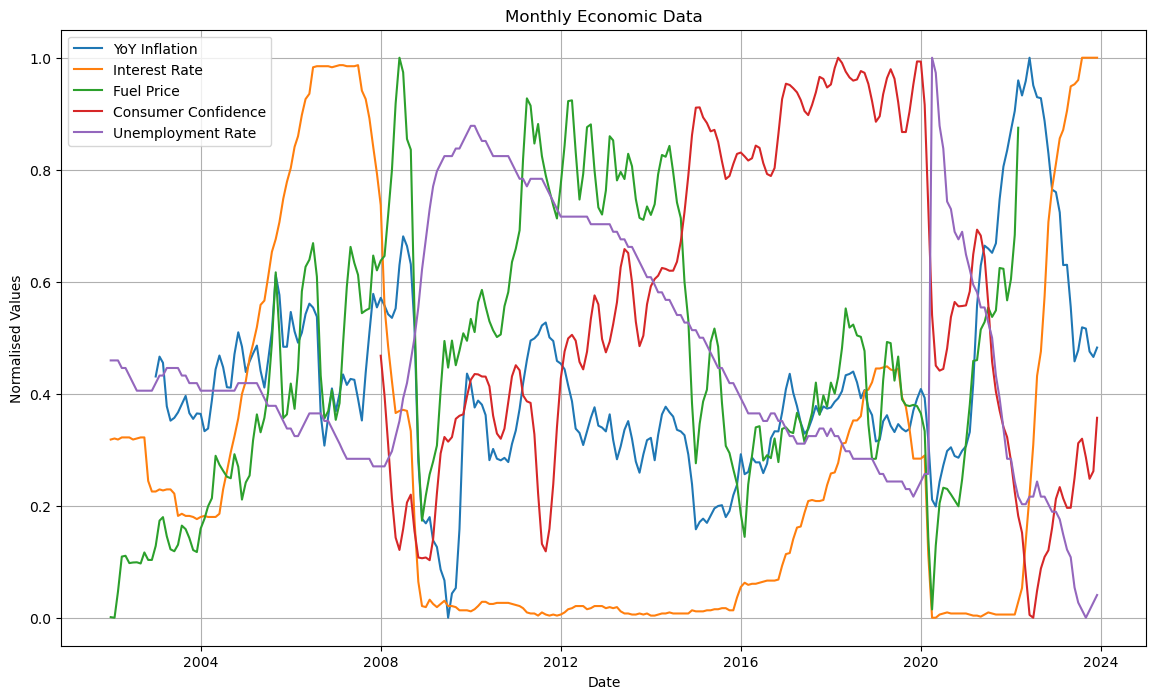

In [56]:
yvalues = [normalise_monthly_economic_data[col] for col in monthly_economic_data.columns]
plot_multiple_series_one_xvalues(monthly_economic_data.index,yvalues,
                                 ['YoY Inflation','Interest Rate','Fuel Price','Consumer Confidence','Unemployment Rate'],
                                 'Monthly Economic Data','Date','Normalised Values')

All monthly variables seem to be independent of one another and will be relevant.

#### Quarterly Economic Data
The following data has been tracked on a quarterly basis.
- Total Payment
- Weekly Wage

In [57]:
quarterly_economic_data = total_payments_thousands.join(weekly_wage)
quarterly_economic_data

,total_payment,weekly_wage
2002-03-01,23526501,757
2002-06-01,23432344,738
2002-09-01,23153527,733
2002-12-01,25477137,802
2003-03-01,24058561,775
...,...,...
2021-12-01,51495703,1498
2022-03-01,47509625,1414
2022-06-01,47282828,1372
2022-09-01,49011315,1417


##### Check for Highly Correlated Variables

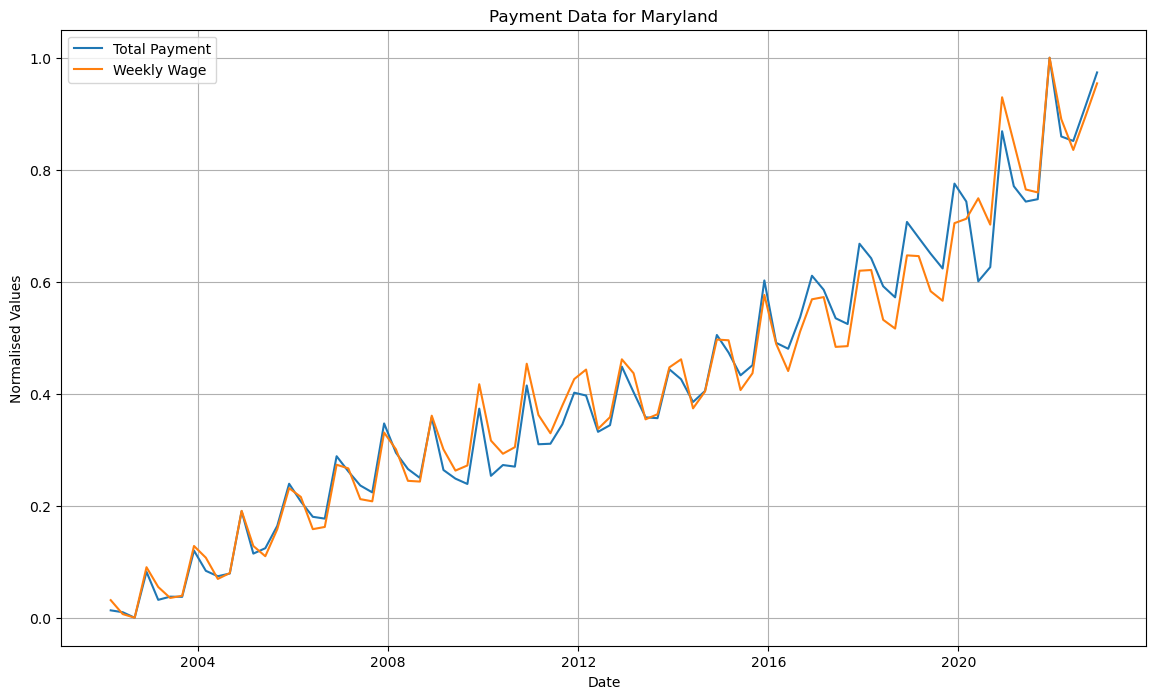

In [58]:
normalise_quarterly_economic_data = normalize_data(quarterly_economic_data)
yvalues = [normalise_quarterly_economic_data[col] for col in quarterly_economic_data.columns]
plot_multiple_series_multiple_xvalues([quarterly_economic_data.index,quarterly_economic_data.index],yvalues,['Total Payment','Weekly Wage'],'Payment Data for Maryland','Date','Normalised Values')

The data follows a very similar trend and pattern. They also reflect similar information so only one is neccessary. As weekly wage is maintained due to government spending during Covid-19 using total payment in the dataframe will be best representative.

##### Monthly Linear Interpolation of Weekly Wage per Quarter
To join to the large dataset, the data needs to be interpolated. As seen above it seems to represent a linear movement, using linear interpolation create monthly data.

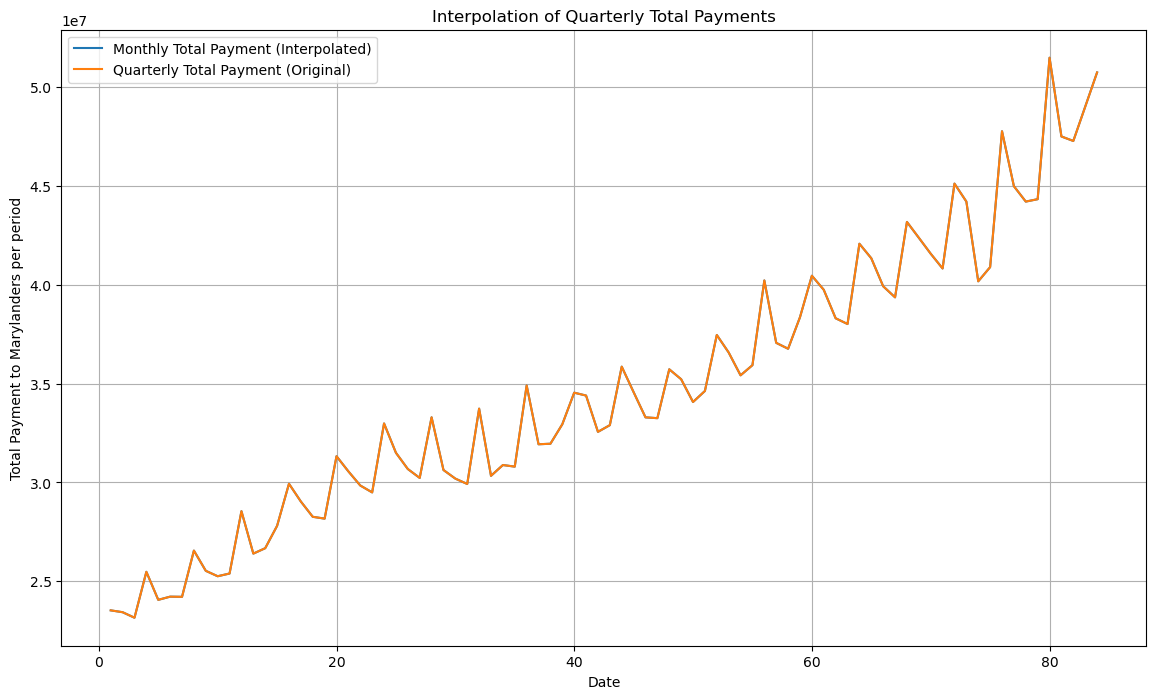

In [59]:
# linear interpolation quarterly data to monthly
from scipy.interpolate import interp1d
import numpy as np
# obtain quarterly data
quarterly_x = np.arange(1, len(quarterly_economic_data) + 1)

# create monthly x values
monthly_x = np.linspace(1, len(quarterly_economic_data), len(quarterly_economic_data) * 3 - 2)

# perform linear interpolation
linear_interpolation = interp1d(quarterly_x, quarterly_economic_data['total_payment'], kind='linear')

# get interpolated total payment for the new monthly x values
linear_interpolation_total_payment = linear_interpolation(monthly_x)

plot_multiple_series_multiple_xvalues([monthly_x,quarterly_x],[linear_interpolation_total_payment,quarterly_economic_data['total_payment']],
                             ['Monthly Total Payment (Interpolated)','Quarterly Total Payment (Original)'],'Interpolation of Quarterly Total Payments',
                             'Date','Total Payment to Marylanders per period')

##### Update Monthly Economic Data

In [60]:
from datetime import timedelta
linear_interpolation_total_payment_df = pd.DataFrame(index = (pd.date_range(start='2002-01-01',end='2022-11-01',freq='M')))
linear_interpolation_total_payment_df['total_payments_thousands'] = linear_interpolation_total_payment
linear_interpolation_total_payment_df.index = (pd.to_datetime(linear_interpolation_total_payment_df.index) - pd.offsets.MonthEnd(1)  + timedelta(days=1))
linear_interpolation_total_payment_df

,total_payments_thousands
2002-01-01,2.352650e+07
2002-02-01,2.349512e+07
2002-03-01,2.346373e+07
2002-04-01,2.343234e+07
2002-05-01,2.333940e+07
...,...
2022-06-01,4.843515e+07
2022-07-01,4.901132e+07
2022-08-01,4.959124e+07
2022-09-01,5.017116e+07


In [61]:
# create new monthly economic data with linear interpolated data
monthly_economic_data.join(linear_interpolation_total_payment_df)

,yoy_inflation,interest_rate,fuel_price,consumer_confidence,unemployment_rate,total_payments_thousands
2002-01-01,NaN,1.73,0.634,NaN,5.0,2.352650e+07
2002-02-01,NaN,1.74,0.631,NaN,5.0,2.349512e+07
2002-03-01,NaN,1.73,0.764,NaN,5.0,2.346373e+07
2002-04-01,NaN,1.75,0.941,NaN,4.9,2.343234e+07
2002-05-01,NaN,1.75,0.945,NaN,4.9,2.333940e+07
...,...,...,...,...,...,...
2023-08-01,3.718721,5.33,NaN,97.94846,1.7,NaN
2023-09-01,3.694055,5.33,NaN,97.76891,1.6,NaN
2023-10-01,3.245787,5.33,NaN,97.56094,1.7,NaN
2023-11-01,3.139482,5.33,NaN,97.63428,1.8,NaN


#### Yearly Economic Data
The following data has been tracked on a yearly basis.
- GDP : Maryland
- Yearly Salary : Maryland

In [62]:
yearly_economic_data = gdp.join(average_salary)
yearly_economic_data

,gdp,annual
date,,
2002-01-01,217001.4,39382.0
2003-01-01,226803.4,40686.0
2004-01-01,243449.8,42579.0
2005-01-01,261795.3,44368.0
2006-01-01,273791.0,46162.0
2007-01-01,282618.2,48241.0
2008-01-01,292908.3,49535.0
2009-01-01,298282.8,50579.0
2010-01-01,313930.5,51739.0


##### Check for correlation between yearly variables.

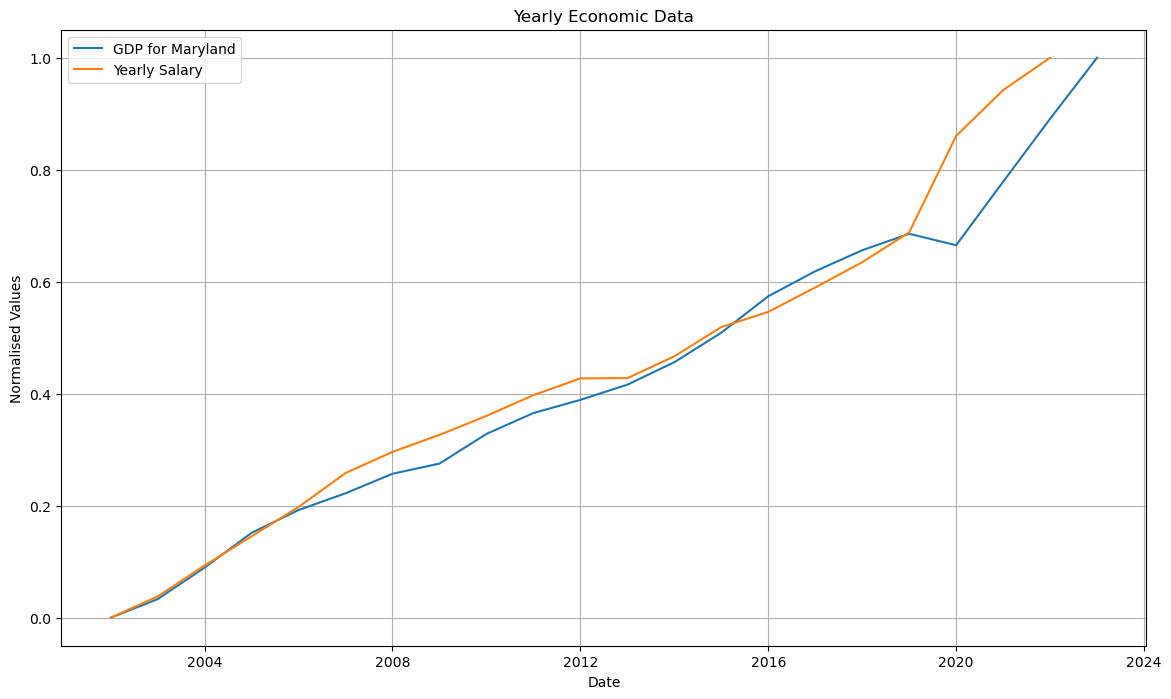

In [63]:
normalise_yearly_economic_data = normalize_data(yearly_economic_data)
plot_multiple_series_one_xvalues(normalise_yearly_economic_data.index,[normalise_yearly_economic_data['gdp'],normalise_yearly_economic_data['annual']],
                             ['GDP for Maryland','Yearly Salary'],'Yearly Economic Data','Date','Normalised Values')

Observe the high correlation between GDP and Yearly salary. It follows a very similar trend until there was a change in 2020. The GDP stays lower than the yearly salary from that point onwards. It continues to grow at the same trend but due to the economic shutdown for a year it will not recover to the same rate. Use Maryland GDP as it takes into account the Covid-19.

##### Linear Interpolation for GDP

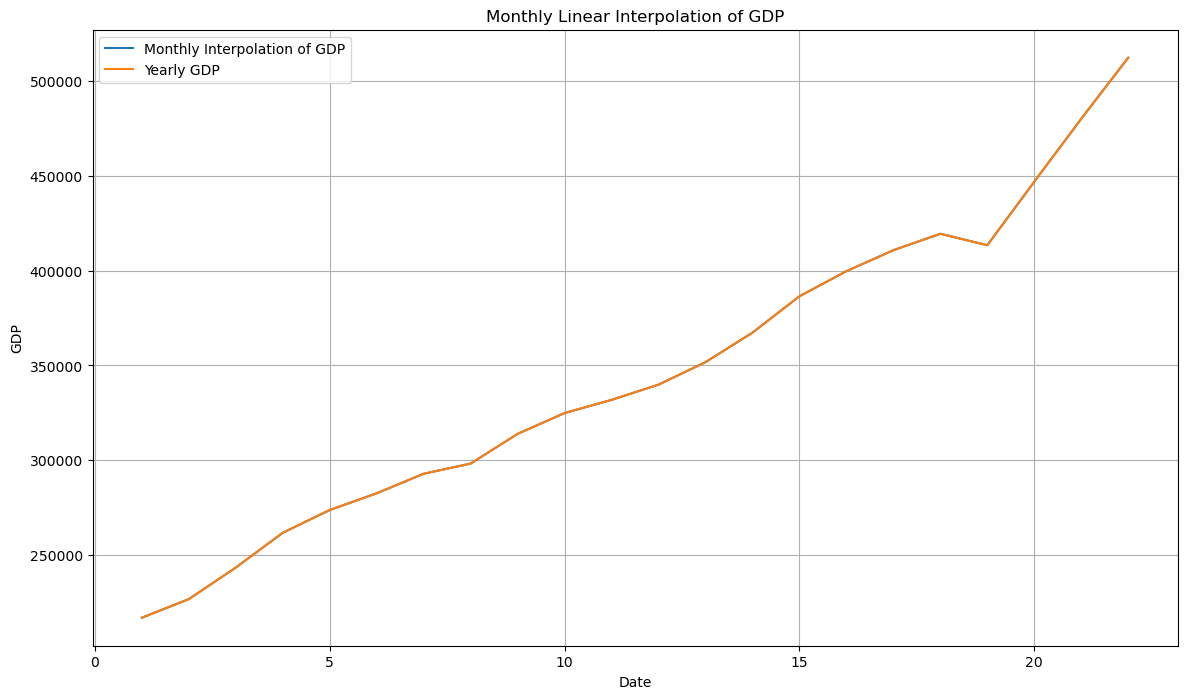

In [64]:
# create x values for yearly data
yearly_x = np.arange(1,len(yearly_economic_data)+1)

# create linear interpolation
linear_interpolation = interp1d(yearly_x,yearly_economic_data['gdp'],'linear')

# create monthly data
monthly_x = np.linspace(1, len(yearly_economic_data), len(yearly_economic_data) * 12 - 11)

# create linear interpolation of gdp
linear_interpolation_gdp = linear_interpolation(monthly_x)

plot_multiple_series_multiple_xvalues([monthly_x,yearly_x],[linear_interpolation_gdp,yearly_economic_data['gdp']],
                             ['Monthly Interpolation of GDP','Yearly GDP'],'Monthly Linear Interpolation of GDP','Date','GDP')

##### Monthly Linear Interpolation of GDP

In [65]:
linear_interpolation_gdp_df = pd.DataFrame(index=(pd.date_range(start='2002-01-01',end='2023-02-01',freq='M')- pd.offsets.MonthEnd(1)+timedelta(days=1)))
linear_interpolation_gdp_df['gdp'] = linear_interpolation_gdp
linear_interpolation_gdp_df['gdp_growth'] = calculate_growth(linear_interpolation_gdp_df,'gdp')
linear_interpolation_gdp_df

,gdp,gdp_growth
2002-01-01,217001.400000,NaN
2002-02-01,217818.233333,0.376418
2002-03-01,218635.066667,0.375007
2002-04-01,219451.900000,0.373606
2002-05-01,220268.733333,0.372215
...,...,...
2022-09-01,501557.233333,0.537321
2022-10-01,504237.800000,0.534449
2022-11-01,506918.366667,0.531608
2022-12-01,509598.933333,0.528797


In [66]:
monthly_economic_data = monthly_economic_data.join(linear_interpolation_gdp_df['gdp_growth'])
monthly_economic_data

,yoy_inflation,interest_rate,fuel_price,consumer_confidence,unemployment_rate,gdp_growth
2002-01-01,NaN,1.73,0.634,NaN,5.0,NaN
2002-02-01,NaN,1.74,0.631,NaN,5.0,0.376418
2002-03-01,NaN,1.73,0.764,NaN,5.0,0.375007
2002-04-01,NaN,1.75,0.941,NaN,4.9,0.373606
2002-05-01,NaN,1.75,0.945,NaN,4.9,0.372215
...,...,...,...,...,...,...
2023-08-01,3.718721,5.33,NaN,97.94846,1.7,NaN
2023-09-01,3.694055,5.33,NaN,97.76891,1.6,NaN
2023-10-01,3.245787,5.33,NaN,97.56094,1.7,NaN
2023-11-01,3.139482,5.33,NaN,97.63428,1.8,NaN


In [67]:
monthly_economic_data.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/combined_data/economic_data.csv')

### Combined Datasets
- Combine car sales and vehicle registration
- Combine yoy inflation, interest rates, fuel prices, consumer confidence, unemployment rate, gdp growth

In [68]:
# combine the economic and car sales data
combined_data = sales_data.join(monthly_economic_data)
combined_data

,total_cars_sold,new_cars_sold,used_cars_sold,total_value_cars_sold,new_value_cars_sold,used_value_cars_sold,electric,plug-in_hybrid,total_electric_sales,yoy_inflation,interest_rate,fuel_price,consumer_confidence,unemployment_rate,gdp_growth
date,,,,,,,,,,,,,,,
2002-01-01,81033,31106,49927,1141497749,755015820,386481929,NaN,NaN,NaN,NaN,1.73,0.634,NaN,5.0,NaN
2002-02-01,78502,27520,50982,1025807465,664454223,361353242,NaN,NaN,NaN,NaN,1.74,0.631,NaN,5.0,0.376418
2002-03-01,93019,34225,58794,1225051631,805666244,419385387,NaN,NaN,NaN,NaN,1.73,0.764,NaN,5.0,0.375007
2002-04-01,96269,36452,59817,1279429447,846368297,433061150,NaN,NaN,NaN,NaN,1.75,0.941,NaN,4.9,0.373606
2002-05-01,97936,37359,60577,1297575194,855005784,442569410,NaN,NaN,NaN,NaN,1.75,0.945,NaN,4.9,0.372215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,78601,25876,52725,2131035952,1222581892,908454060,55728.0,25360.0,81088.0,3.718721,5.33,NaN,97.94846,1.7,NaN
2023-09-01,69278,23892,45386,1879114283,1134437699,744676584,58157.0,26022.0,84179.0,3.694055,5.33,NaN,97.76891,1.6,NaN
2023-10-01,69248,23775,45473,1863262680,1122680147,740582533,60136.0,26951.0,87087.0,3.245787,5.33,NaN,97.56094,1.7,NaN
